<center><img src='./Figs/cs-logo.png' width=200></center>



<h6><center></center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center> Mention IA - Reinforcement Learning - Task 2</center>
<hr style=" border:none; height:3px;">
</h1>

In [1]:
! pip install gymnasium
! pip install highway-env


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import gymnasium as gym
from matplotlib import pyplot as plt
import pprint
import highway_env
import time
from IPython.display import clear_output


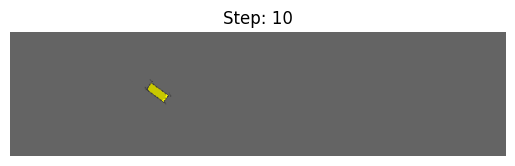

In [ ]:
env_config = {
    "action": {
        "type": "ContinuousAction",
    }
}


# Assure that the environment is for continuous actions
env = gym.make("highway-v0", render_mode='rgb_array')
env.unwrapped.configure({
    "action": {
        "type": "ContinuousAction",
        "longitudinal": True,
        "lateral": True
    },
    
})

observation = env.reset()

# Visualize initial state
plt.imshow(env.render())
plt.title("Initial State")
plt.axis('off')  
plt.show()

# Perform 10 steps with random continuous actions
for step in range(10):
    action = env.action_space.sample()  
    observation, reward, done, truncated, info = env.step(action)  # Adjusted to include 'truncated'
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.title(f"Step: {step + 1}")
    plt.axis('off')
    plt.show()
    time.sleep(0.1)  
    if done or truncated: 
        print("Episode ended after this step. Resetting environment.")
        observation = env.reset()

In [ ]:
import pickle


with open("config_highway_continuous.pkl", "rb") as f:
    config = pickle.load(f)

# configure the environment
env = gym.make("highway-v0", render_mode="rgb_array")
env.unwrapped.configure(config)  
print(config.get("action"))

{'type': 'ContinuousAction'}


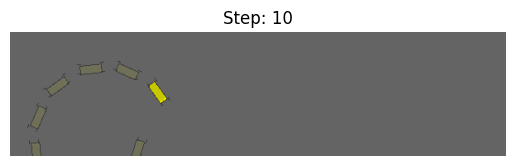

In [ ]:
import pickle


with open("config_highway_continuous.pkl", "rb") as f:
    config = pickle.load(f)

env = gym.make("highway-v0", render_mode="rgb_array")
env.unwrapped.configure(config)  
print(config.get("action"))
observation = env.reset()

# Visualize initial state
plt.imshow(env.render())
plt.title("Initial State")
plt.axis('off')  
plt.show()

# Perform 10 steps with random continuous actions
for step in range(10):
    action = env.action_space.sample()  # Sample a random action
    print(action)
    observation, reward, done, truncated, info = env.step(action)
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.title(f"Step: {step + 1}")
    plt.axis('off')
    plt.show()
    time.sleep(0.1)  
    if done or truncated:
        print("Episode ended after this step. Resetting environment.")
        observation = env.reset()

# Close the environment when done
env.close()

In [21]:
print(env.action_space)
print("Observation space:", env.observation_space)


Box(-1.0, 1.0, (2,), float32)
Observation space: Box(-inf, inf, (7, 8, 8), float32)


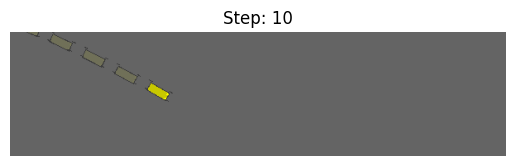

In [ ]:
import numpy as np

# Defining a function to sample minor steering and acceleration
def sample_small_actions():
   
    acceleration = np.random.uniform(-0.05, 0.05)
    steering = np.random.uniform(-0.05, 0.05)
    return np.array([acceleration, steering], dtype=np.float32)

# Now we use this function in our loop
for _ in range(10):
    action = sample_small_actions()
    observation, reward, done, truncated, info = env.step(action)
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.title(f"Step: {step + 1}")
    plt.axis('off')
    plt.show()
    time.sleep(0.1)  
    if done or truncated:
        print("Episode ended after this step. Resetting environment.")
        observation = env.reset()

# Close the environment when done
env.close()

### **<span style="color:red">First approach using DDPG</span>**

In this first approach, I worked on training a DDPG agent in the highway-v0 environment using continuous control. I started by setting up the environment with a custom configuration that uses an occupancy grid for observations and continuous actions for more nuanced control. To guide the agent's behavior, I designed a custom reward function that encourages safe and efficient driving — rewarding higher speeds, staying in the right lane, and avoiding collisions. For exploration, I used the Ornstein-Uhlenbeck noise process, which helps the agent explore in a more stable way. The actor and critic networks were trained using experiences stored in a replay buffer, and their target networks were updated gradually over time. Throughout the 100 training episodes, I tracked both individual and average rewards to monitor progress. This setup gave me more control over how the agent learns.

In [23]:
import numpy as np
from collections import deque
import random
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.autograd
from torch.autograd import Variable
import torch.optim as optim
import sys
import pandas as pd
import matplotlib.pyplot as plt

import gym
import highway_env

In [24]:
# Ornstein-Ulhenbeck Process
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        #print(f"Action dimension: {self.action_dim}, Low: {action_space.low}, High: {action_space.high}")
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        new_action = np.clip(action + ou_state, self.low, self.high)
        #print(f"New action from OUNoise: {new_action}, Shape: {new_action.shape}")
        return new_action

class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def _action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def _reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)
        

class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

In [25]:
agento = OUNoise(env.action_space)

In [26]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        action = action.squeeze()
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

In [27]:
env.observation_space.shape[0]
np.prod(env.observation_space.shape)
env.action_space.shape[0]

2

In [ ]:
class DDPGagent:
    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=0.005, max_memory_size=50000):
        # Params
        self.num_states = np.prod(env.observation_space.shape)
        # self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        print("training")
        self.memory = Memory(max_memory_size)        
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
    
    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state).detach().cpu().numpy()

        return action
    
    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        # print(states)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
    
        # Critic loss        
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()

        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

In [29]:
agento = DDPGagent(env)

training


In [30]:
env.action_space.shape[0]

2

In [ ]:
sample_action = env.action_space.sample()  
output = env.step(sample_action)
print(f"Step method returned {len(output)} items")
print(output)

Step method returned 5 items
(array([[[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          1.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        , 

training


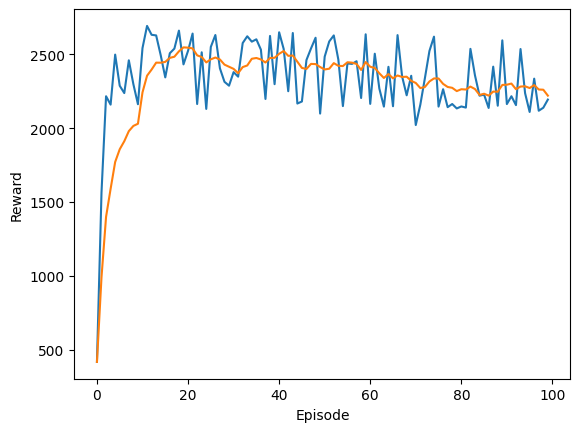

In [ ]:
# Instantiate the agent and the Ornstein-Uhlenbeck process
agent = DDPGagent(env)
noise = OUNoise(env.action_space)
batch_size = 128
rewards = []
avg_rewards = []

def calculate_custom_reward(info):
    # Custom reward function that emphasizes speed and staying on the road
    reward = 0
    reward += max(0, info['speed'] / 10)  # Normalize speed to a positive value
    reward += info['rewards']['right_lane_reward']
    reward += info['rewards']['high_speed_reward']
    reward += info['rewards']['on_road_reward']
    if info['crashed']:
        reward -= 50  # Large penalty for crashing
    return reward

# Training Loop
for episode in range(100):
    raw_state, info = env.reset()  
    state = raw_state.flatten()
    #print(f"Contents of state: {state}")
    # Assuming state is a NumPy array, we can directly flatten it
    noise.reset()
    episode_reward = 0
    
    for step in range(500):
        action = agent.get_action(state)
        action = noise.get_action(action, step)
        new_state, reward, done, truncated, info = env.step(action[0])  
        reward = calculate_custom_reward(info)
        # print(f"Action: {action}, Reward: {reward}, Info: {info}")  # Debug output
        new_state = new_state.flatten()
        
        agent.memory.push(state, action, reward, new_state, done)
        
        if len(agent.memory) > batch_size:
            agent.update(batch_size)
        
        state = new_state
        episode_reward += reward

        if done:
            print(f"Episode: {episode}, total reward: {episode_reward}")
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

# Plot the results
plt.plot(rewards)
plt.plot(avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [ ]:
print(agent.get_action(state))

In [ ]:
import time


obs, info = env.reset()
for _ in range(200):
    state = obs.flatten()
    action = agent.get_action(state).flatten()
    obs, reward, done, truncated, info = env.step(action)
    
    env.render()          
    time.sleep(0.02)      
    
    if done or truncated:
        break
    env.render()
env.close()



In second time , to better understand how robust and stable our DDPG agent is, I ran multiple training sessions using different random seeds. This helps reveal whether the agent's performance is consistent or highly sensitive to initialization and randomness. For each seed, I trained a fresh agent from scratch and recorded the total reward over 100 episodes. This step was essential to validate the reliability of the agent before moving forward with more advanced modifications.


 Training with seed 0
training

 Training with seed 1
training

 Training with seed 42
training

 Training with seed 123
training

 Training with seed 999
training
   seed  final_reward  avg_last_10  reward_std
0     0      0.000000     4.423423    3.038153
1     1     24.604167     6.018356    7.046222
2    42     15.503286     5.846560    5.837269
3   123     12.575175    11.970203    9.287662
4   999      4.054295     1.361128    1.269829


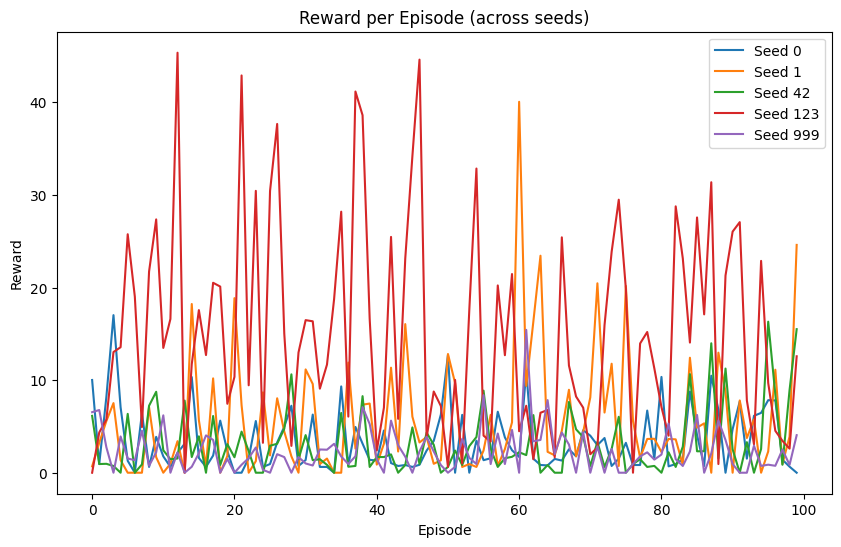

In [39]:
import torch
import numpy as np
import random
import gymnasium as gym
from copy import deepcopy

seeds = [0, 1, 42, 123, 999]
results = []

for seed in seeds:
    print(f"\n Training with seed {seed}")
    
    # Set seeds
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    
    # Create and configure env
    env = gym.make("highway-v0", render_mode="rgb_array")
    env.unwrapped.configure(deepcopy(config))  # use deepcopy to isolate configs
    env.reset(seed=seed)
    
    # Initialize a fresh agent and noise
    agent = DDPGagent(env)
    noise = OUNoise(env.action_space)
    
    rewards = []
    
    # Training loop
    for episode in range(100):
        state, _ = env.reset()
        noise.reset()
        episode_reward = 0
        for _ in range(500):
            state = state.flatten()
            action = agent.get_action(state).flatten()
            action = noise.get_action(action)

            new_state, reward, done, truncated, _ = env.step(action)
            new_state = new_state.flatten()
            
            agent.memory.push(state, action, reward, new_state, done)
            if len(agent.memory) > 128:
                agent.update(128)
            
            state = new_state
            episode_reward += reward
            if done or truncated:
                break
        
        rewards.append(episode_reward)
    
    # Store final metrics
    result = {
        "seed": seed,
        "final_reward": rewards[-1],
        "avg_last_10": np.mean(rewards[-10:]),
        "reward_std": np.std(rewards[-10:]),
        "all_rewards": rewards  # optional, for plotting
    }
    results.append(result)

    env.close()
import pandas as pd

df = pd.DataFrame(results)
print(df[["seed", "final_reward", "avg_last_10", "reward_std"]])
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for r in results:
    plt.plot(r["all_rewards"], label=f"Seed {r['seed']}")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward per Episode (across seeds)")
plt.legend()
plt.show()

df.to_csv("ddpg_seed_results.csv", index=False)


After observing inconsistent and noisy results across different seeds in the initial experiments, I refined the training setup to stabilize the agent’s learning. Specifically, I increased the number of vehicles in the environment to intensify the traffic complexity and tuned the simulation and policy frequencies to better reflect realistic decision-making intervals. The custom reward function was also preserved to emphasize lane discipline and speed while strongly penalizing collisions. To reduce exploration noise over time, I used a decaying Ornstein-Uhlenbeck process. 

training
 Episode 1, Reward: 645.8148738191941, Avg10: 645.81
 Episode 2, Reward: 1439.9159665296227, Avg10: 1042.87
 Episode 3, Reward: 1525.5484701450964, Avg10: 1203.76
 Episode 4, Reward: 1677.0002294370115, Avg10: 1322.07
 Episode 5, Reward: 1662.2962869427572, Avg10: 1390.12
 Episode 6, Reward: 1673.606284548614, Avg10: 1437.36
 Episode 7, Reward: 1740.8546298006734, Avg10: 1480.72
 Episode 8, Reward: 1737.1691431686756, Avg10: 1512.78
 Episode 9, Reward: 1765.2717828798766, Avg10: 1540.83
 Episode 10, Reward: 1755.6779064272223, Avg10: 1562.32
 Episode 11, Reward: 1.8475508015057613, Avg10: 1497.92
 Episode 12, Reward: 54.18764244186334, Avg10: 1359.35
 Episode 13, Reward: 1779.8485582624785, Avg10: 1384.78
 Episode 14, Reward: 1780.5876927911809, Avg10: 1395.13
 Episode 15, Reward: 1764.3151796548013, Avg10: 1405.34
 Episode 16, Reward: 1767.8529672510874, Avg10: 1414.76
 Episode 17, Reward: 59.648822608289485, Avg10: 1246.64
 Episode 18, Reward: 1761.2014859311944, Avg10: 1249

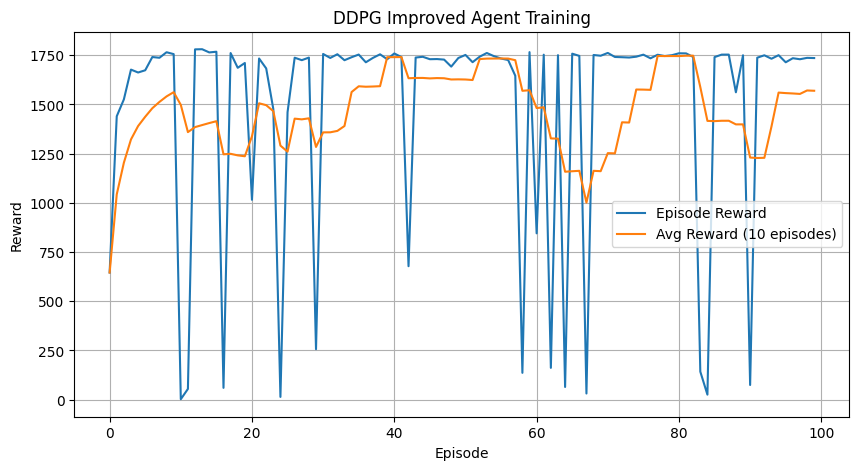

In [ ]:
import torch
import numpy as np
import random
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque
from copy import deepcopy

# Clean reward shaping
def calculate_custom_reward(info):
    reward = 0
    reward += max(0, info.get('speed', 0) / 10)
    reward += info.get('rewards', {}).get('right_lane_reward', 0)
    reward += info.get('rewards', {}).get('high_speed_reward', 0)
    reward += info.get('rewards', {}).get('on_road_reward', 0)
    if info.get('crashed', False):
        reward -= 50
    return reward

# Hyperparameters
SEED = 42
EPISODES = 100
STEPS = 500
BATCH_SIZE = 128
HIDDEN_SIZE = 256

# Set seeds
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# Create and configure environment
env = gym.make("highway-v0", render_mode="rgb_array")
config["vehicles_count"] = 20
config["simulation_frequency"] = 15
config["policy_frequency"] = 5
env.unwrapped.configure(deepcopy(config))
env.reset(seed=SEED)


agent = DDPGagent(env, hidden_size=HIDDEN_SIZE)
noise = OUNoise(env.action_space, max_sigma=0.2, min_sigma=0.05)

rewards = []
avg_rewards = []

# Train loop
for episode in range(EPISODES):
    raw_state, info = env.reset()
    state = raw_state.flatten()
    episode_reward = 0
    noise.reset()

    for step in range(STEPS):
        action = agent.get_action(state).flatten()
        action = noise.get_action(action, t=episode * STEPS + step)
        new_state, reward, done, truncated, info = env.step(action)
        reward = calculate_custom_reward(info)
        new_state = new_state.flatten()

        agent.memory.push(state, action, reward, new_state, done)

        if len(agent.memory) > BATCH_SIZE:
            agent.update(BATCH_SIZE)

        state = new_state
        episode_reward += reward

        if done or truncated:
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))
    print(f" Episode {episode+1}, Reward: {episode_reward}, Avg10: {avg_rewards[-1]:.2f}")

env.close()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Episode Reward")
plt.plot(avg_rewards, label="Avg Reward (10 episodes)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DDPG Improved Agent Training")
plt.legend()
plt.grid(True)
plt.show()


In [45]:
obs, _ = env.reset()
total_reward = 0

for _ in range(200):
    action = agent.get_action(obs.flatten()).flatten()
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward
    env.render()
    if done or truncated:
        break

env.close()
print("Evaluation reward:", total_reward)


Evaluation reward: 2.5171509414979854


After several iterations of training with DDPG, I noticed that while the agent could achieve high rewards, its performance was often unstable and noisy due to the persistent exploration throughout training. To try and fix this, I introduced a faster decay in the Ornstein-Uhlenbeck noise process, allowing the agent to explore early on but stabilize its policy over time. I also added periodic evaluations every 10 episodes, using a noise-free policy to measure the agent’s actual competence without stochastic interference. On top of that, I tuned the environment with higher vehicle density and adjusted simulation and policy frequencies to create a more dynamic yet realistic traffic scenario. The reward shaping was preserved and kept simple yet effective to prioritize high speed, lane discipline, and road adherence while discouraging collisions.

training
 Episode 1, Train: 645.24, Eval: 77.13, Avg10: 645.24
Episode 2, Train: 1322.03, Avg10: 983.64
Episode 3, Train: 1529.86, Avg10: 1165.71
Episode 4, Train: 1593.44, Avg10: 1272.64
Episode 5, Train: 1692.17, Avg10: 1356.55
Episode 6, Train: 1705.10, Avg10: 1414.64
Episode 7, Train: 1786.06, Avg10: 1467.70
Episode 8, Train: 1758.74, Avg10: 1504.08
Episode 9, Train: 87.20, Avg10: 1346.65
Episode 10, Train: 1787.71, Avg10: 1390.76
 Episode 11, Train: 1769.53, Eval: 12.14, Avg10: 1503.19
Episode 12, Train: 163.80, Avg10: 1387.36
Episode 13, Train: 3.88, Avg10: 1234.76
Episode 14, Train: 1787.46, Avg10: 1254.17
Episode 15, Train: 1763.65, Avg10: 1261.31
Episode 16, Train: 1765.05, Avg10: 1267.31
Episode 17, Train: 1759.83, Avg10: 1264.69
Episode 18, Train: 1762.34, Avg10: 1265.05
Episode 19, Train: 1770.53, Avg10: 1433.38
Episode 20, Train: 11.00, Avg10: 1255.71
 Episode 21, Train: 1772.34, Eval: 3.99, Avg10: 1255.99
Episode 22, Train: 7.75, Avg10: 1240.38
Episode 23, Train: 1769.30,

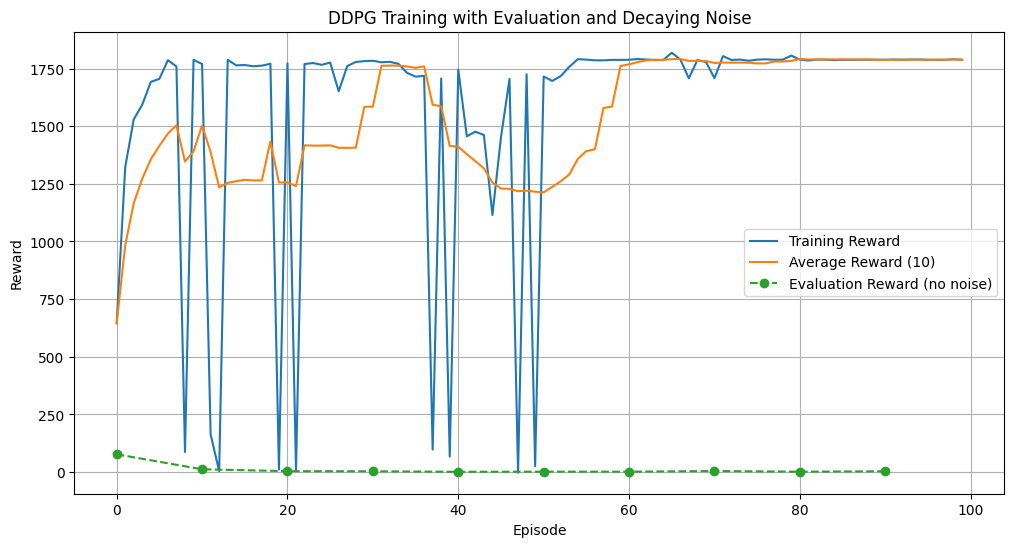

In [ ]:
import torch
import numpy as np
import random
import gymnasium as gym
import matplotlib.pyplot as plt
from copy import deepcopy

# 1 Reward Shaping Function
def calculate_custom_reward(info):
    reward = 0
    reward += max(0, info.get('speed', 0) / 10)
    reward += info.get('rewards', {}).get('right_lane_reward', 0)
    reward += info.get('rewards', {}).get('high_speed_reward', 0)
    reward += info.get('rewards', {}).get('on_road_reward', 0)
    if info.get('crashed', False):
        reward -= 50
    return reward

# 2 Seed Setup
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# 3 Environment Setup
env = gym.make("highway-v0", render_mode="rgb_array")
config["vehicles_count"] = 20
config["simulation_frequency"] = 15
config["policy_frequency"] = 5
env.unwrapped.configure(deepcopy(config))
env.reset(seed=SEED)

# 4 Agent and Noise with faster decay
agent = DDPGagent(env)
noise = OUNoise(env.action_space, max_sigma=0.2, min_sigma=0.02, decay_period=30000)  # Faster decay

# 5 Training Parameters
EPISODES = 100
STEPS = 500
BATCH_SIZE = 128
rewards = []
avg_rewards = []
eval_rewards = []

# 6 Training Loop + Evaluation Every 10 Episodes
for episode in range(EPISODES):
    raw_state, info = env.reset()
    state = raw_state.flatten()
    noise.reset()
    episode_reward = 0

    for step in range(STEPS):
        action = agent.get_action(state).flatten()
        action = noise.get_action(action, t=episode * STEPS + step)  # noise-decay over time
        new_state, reward, done, truncated, info = env.step(action)
        reward = calculate_custom_reward(info)
        new_state = new_state.flatten()

        agent.memory.push(state, action, reward, new_state, done)
        if len(agent.memory) > BATCH_SIZE:
            agent.update(BATCH_SIZE)

        state = new_state
        episode_reward += reward
        if done or truncated:
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

    # 7 Evaluation without noise every 10 episodes
    if episode % 10 == 0:
        eval_state, _ = env.reset()
        eval_state = eval_state.flatten()
        eval_reward = 0
        for _ in range(200):
            eval_action = agent.get_action(eval_state).flatten()  # No noise!
            eval_state_, r, done, truncated, _ = env.step(eval_action)
            eval_state = eval_state_.flatten()
            eval_reward += r
            if done or truncated:
                break
        eval_rewards.append((episode, eval_reward))
        print(f" Episode {episode+1}, Train: {episode_reward:.2f}, Eval: {eval_reward:.2f}, Avg10: {avg_rewards[-1]:.2f}")
    else:
        print(f"Episode {episode+1}, Train: {episode_reward:.2f}, Avg10: {avg_rewards[-1]:.2f}")

env.close()

# 8 Plotting
plt.figure(figsize=(12, 6))
plt.plot(rewards, label="Training Reward")
plt.plot(avg_rewards, label="Average Reward (10)")
if eval_rewards:
    eval_ep, eval_vals = zip(*eval_rewards)
    plt.plot(eval_ep, eval_vals, label="Evaluation Reward (no noise)", linestyle="--", marker='o')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DDPG Training with Evaluation and Decaying Noise")
plt.legend()
plt.grid(True)
plt.show()


Finally , given that previous evaluations with decaying noise showed strong training performance but flat evaluation results, we noticed that the agent had become too dependent on the added exploration noise to act optimally. To fix this, we implemented a more structured approach by disabling noise every 5th episode during training, encouraging the agent to occasionally rely solely on its learned policy. This not only served as an implicit form of validation but also guided the agent to better generalize its behavior without constant perturbation. Additionally, we maintained dedicated noise-free evaluation runs every 10 episodes to explicitly measure true policy performance.

In [46]:
obs, _ = env.reset()
for _ in range(200):
    action = agent.get_action(obs.flatten()).flatten()  # NO noise
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done or truncated:
        break


In [48]:
# --- Updated DDPG with periodic noise-free training and evaluation ---
EPISODES = 200
STEPS = 500
BATCH_SIZE = 128
rewards = []
avg_rewards = []
eval_rewards = []

# Faster-decaying noise
noise = OUNoise(env.action_space, max_sigma=0.2, min_sigma=0.01, decay_period=15000)

for episode in range(EPISODES):
    raw_state, _ = env.reset()
    state = raw_state.flatten()
    episode_reward = 0
    noise.reset()

    for step in range(STEPS):
        action = agent.get_action(state).flatten()

        #  Every 5th episode = no noise
        if episode % 5 != 0:
            action = noise.get_action(action, t=episode * STEPS + step)

        next_state, reward, done, truncated, info = env.step(action)
        reward = calculate_custom_reward(info)
        next_state = next_state.flatten()

        agent.memory.push(state, action, reward, next_state, done)
        if len(agent.memory) > BATCH_SIZE:
            agent.update(BATCH_SIZE)

        state = next_state
        episode_reward += reward
        if done or truncated:
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

    # Evaluation without noise
    if episode % 10 == 0:
        eval_obs, _ = env.reset()
        eval_state = eval_obs.flatten()
        eval_reward = 0
        for _ in range(200):
            eval_action = agent.get_action(eval_state).flatten()
            eval_state_, r, done, truncated, _ = env.step(eval_action)
            eval_state = eval_state_.flatten()
            eval_reward += r
            if done or truncated:
                break
        eval_rewards.append((episode, eval_reward))
        print(f"EP {episode+1}: Train {episode_reward:.1f}, Eval {eval_reward:.1f}, Avg10 {avg_rewards[-1]:.1f}")
    else:
        print(f" EP {episode+1}: Train {episode_reward:.1f}, Avg10 {avg_rewards[-1]:.1f}")


EP 1: Train 484.9, Eval 3.2, Avg10 484.9
 EP 2: Train 1318.7, Avg10 901.8
 EP 3: Train 1283.4, Avg10 1029.0
 EP 4: Train 1282.8, Avg10 1092.4
 EP 5: Train 1274.6, Avg10 1128.9
 EP 6: Train 1378.9, Avg10 1170.5
 EP 7: Train 1718.4, Avg10 1248.8
 EP 8: Train 1739.5, Avg10 1310.1
 EP 9: Train 1648.2, Avg10 1347.7
 EP 10: Train 133.9, Avg10 1226.3
EP 11: Train 1714.4, Eval 8.3, Avg10 1349.3
 EP 12: Train 332.0, Avg10 1250.6
 EP 13: Train 68.1, Avg10 1129.1
 EP 14: Train 262.7, Avg10 1027.1
 EP 15: Train 10.1, Avg10 900.6
 EP 16: Train 1681.9, Avg10 930.9
 EP 17: Train 1713.8, Avg10 930.5
 EP 18: Train 1743.1, Avg10 930.8
 EP 19: Train 1773.6, Avg10 943.4
 EP 20: Train 1797.1, Avg10 1109.7
EP 21: Train 1784.6, Eval 2.6, Avg10 1116.7
 EP 22: Train 1780.4, Avg10 1261.5
 EP 23: Train 1779.7, Avg10 1432.7
 EP 24: Train 1782.7, Avg10 1584.7
 EP 25: Train 1780.0, Avg10 1761.7
 EP 26: Train 1790.7, Avg10 1772.6
 EP 27: Train 1785.0, Avg10 1779.7
 EP 28: Train 1782.7, Avg10 1783.7
 EP 29: Train 32.

### **<span style="color:red">Second approach</span>**

After observing a consistent pattern where the DDPG agent performed well during training but failed to generalize in evaluation—largely due to its reliance on exploration noise—we decided to switch to the Twin Delayed Deep Deterministic Policy Gradient (TD3) algorithm. TD3 handles some of DDPG’s core weaknesses by adding a second critic network to mitigate overestimation bias, introducing clipped noise for smoother target policy updates, and delaying actor updates to stabilize learning. These additions help the agent learn a more robust policy that's less sensitive to noise and more transferable to evaluation settings.

In [47]:
class TD3agent(DDPGagent):
    def __init__(self, env, hidden_size=256, actor_lr=1e-4, critic_lr=1e-3, gamma=0.99, tau=0.005):
        super().__init__(env, hidden_size, actor_lr, critic_lr, gamma, tau)
        # Add second critic for TD3
        self.critic2 = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic2_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        for tp, p in zip(self.critic2_target.parameters(), self.critic2.parameters()):
            tp.data.copy_(p.data)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=critic_lr)
        self.policy_delay = 2
        self.total_it = 0

    def update(self, batch_size):
        self.total_it += 1
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)

        # TD3 target policy smoothing
        noise = torch.randn_like(actions) * 0.2
        noise = torch.clamp(noise, -0.5, 0.5)
        next_actions = self.actor_target(next_states) + noise
        next_actions = torch.clamp(next_actions, -1.0, 1.0)

        target_Q1 = self.critic_target(next_states, next_actions.detach())
        target_Q2 = self.critic2_target(next_states, next_actions.detach())
        target_Q = torch.min(target_Q1, target_Q2)
        Qprime = rewards + self.gamma * target_Q

        # Critic updates
        Q1 = self.critic(states, actions)
        Q2 = self.critic2(states, actions)
        critic_loss = F.mse_loss(Q1, Qprime.detach()) + F.mse_loss(Q2, Qprime.detach())

        self.critic_optimizer.zero_grad()
        self.critic2_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        self.critic2_optimizer.step()

        # Delay actor update
        if self.total_it % self.policy_delay == 0:
            actor_loss = -self.critic(states, self.actor(states)).mean()
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update targets
            for tp, p in zip(self.actor_target.parameters(), self.actor.parameters()):
                tp.data.copy_(p.data * self.tau + tp.data * (1.0 - self.tau))
            for tp, p in zip(self.critic_target.parameters(), self.critic.parameters()):
                tp.data.copy_(p.data * self.tau + tp.data * (1.0 - self.tau))
            for tp, p in zip(self.critic2_target.parameters(), self.critic2.parameters()):
                tp.data.copy_(p.data * self.tau + tp.data * (1.0 - self.tau))
agent = TD3agent(env)


training


In [ ]:
#running the training loop exactly like for DDPG
rewards = []
avg_rewards = []
eval_rewards = []

noise = OUNoise(env.action_space, max_sigma=0.2, min_sigma=0.01, decay_period=15000)

for episode in range(200):
    raw_state, _ = env.reset()
    state = raw_state.flatten()
    episode_reward = 0
    noise.reset()

    for step in range(500):
        action = agent.get_action(state).flatten()

        if episode % 5 != 0:
            action = noise.get_action(action, t=episode * 500 + step)

        next_state, reward, done, truncated, info = env.step(action)
        reward = calculate_custom_reward(info)
        next_state = next_state.flatten()

        agent.memory.push(state, action, reward, next_state, done)
        if len(agent.memory) > 128:
            agent.update(128)

        state = next_state
        episode_reward += reward

        if done or truncated:
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

    # Evaluation every 10 episodes
    if episode % 10 == 0:
        eval_obs, _ = env.reset()
        eval_state = eval_obs.flatten()
        eval_reward = 0
        for _ in range(200):
            eval_action = agent.get_action(eval_state).flatten()
            eval_state_, r, done, truncated, _ = env.step(eval_action)
            eval_state = eval_state_.flatten()
            eval_reward += r
            if done or truncated:
                break
        eval_rewards.append((episode, eval_reward))
        print(f" TD3 EP {episode+1}: Train {episode_reward:.1f}, Eval {eval_reward:.1f}, Avg10 {avg_rewards[-1]:.1f}")
    else:
        print(f" TD3 EP {episode+1}: Train {episode_reward:.1f}, Avg10 {avg_rewards[-1]:.1f}")


 TD3 EP 1: Train 1771.8, Eval 5.2, Avg10 1771.8
 TD3 EP 2: Train 1616.0, Avg10 1693.9
 TD3 EP 3: Train 1692.6, Avg10 1693.5
 TD3 EP 4: Train 1644.3, Avg10 1681.2
 TD3 EP 5: Train 1721.3, Avg10 1689.2
 TD3 EP 6: Train 1769.7, Avg10 1702.6
 TD3 EP 7: Train 1705.4, Avg10 1703.0
 TD3 EP 8: Train 1721.2, Avg10 1705.3
 TD3 EP 9: Train 1719.9, Avg10 1706.9
 TD3 EP 10: Train 1730.8, Avg10 1709.3
 TD3 EP 11: Train 1774.3, Eval 5.6, Avg10 1709.5
 TD3 EP 12: Train 1722.8, Avg10 1720.2
 TD3 EP 13: Train 1728.8, Avg10 1723.8
 TD3 EP 14: Train 1730.8, Avg10 1732.5
 TD3 EP 15: Train 1731.6, Avg10 1733.5
 TD3 EP 16: Train 1778.9, Avg10 1734.4
 TD3 EP 17: Train 1720.5, Avg10 1735.9
 TD3 EP 18: Train 1733.4, Avg10 1737.2
 TD3 EP 19: Train 1737.1, Avg10 1738.9
 TD3 EP 20: Train 1734.4, Avg10 1739.2
 TD3 EP 21: Train 1786.3, Eval 2.8, Avg10 1740.4
 TD3 EP 22: Train 1763.5, Avg10 1744.5
 TD3 EP 23: Train 1750.4, Avg10 1746.7
 TD3 EP 24: Train 1754.6, Avg10 1749.1
 TD3 EP 25: Train 1748.0, Avg10 1750.7
 TD3

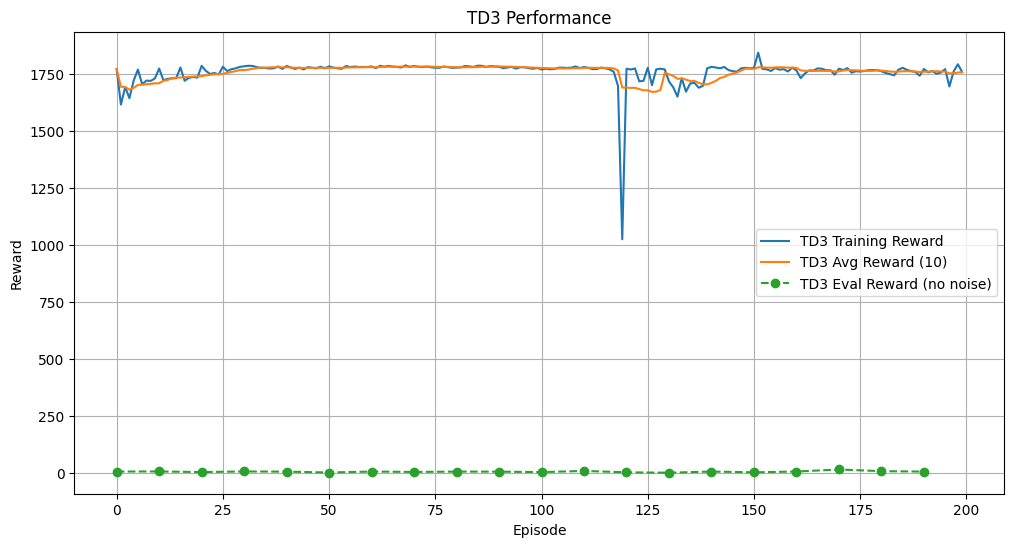

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(rewards, label="TD3 Training Reward")
plt.plot(avg_rewards, label="TD3 Avg Reward (10)")
if eval_rewards:
    ep, val = zip(*eval_rewards)
    plt.plot(ep, val, '--o', label="TD3 Eval Reward (no noise)")
plt.title("TD3 Performance")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.show()


### **<span style="color:red">Final Approach</span>**

After observing that our DDPG and TD3 agents performed well during training but consistently failed during evaluation—likely due to poor generalization and high sensitivity to noise—we explored a different strategy based on Proximal Policy Optimization (PPO) , which  is a powerful on-policy reinforcement learning algorithm known for its training stability and robustness, PPO simplifies policy updates by clipping the objective function, which prevents overly aggressive policy changes and promotes gradual improvement. This is particularly helpful when shaping rewards, as it allows the agent to adapt smoothly without diverging. Additionally, since PPO learns directly from the latest trajectories, it's well-suited for autonomous driving simulations.To evaluate this approach, we used a reward shaping function focused on lane discipline, speed, and avoiding crashes. We manually flattened the high-dimensional grid observations and recorded both numerical rewards and qualitative video rollouts of the trained agent’s driving behavior. Overall, PPO served as a valuable baseline to test whether a more stable policy gradient method could overcome the generalization gaps encountered with actor-critic off-policy algorithms.



In [11]:
# In a notebook cell, run:
! pip install stable-baselines3[extra]


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ----------------------------------- ---- 1.3/1.5 MB 7.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 6.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 26   |
|    iterations      | 1    |
|    time_elapsed    | 38   |
|    total_timesteps | 1024 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 79          |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.007098968 |
|    clip_fraction        | 0.0856      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.85       |
|    explained_variance   | -0.0319     |
|    learning_rate        | 0.0005      |
|    loss                 | 6.28        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00976    |
|    std                  | 1.01        |
|    value_loss           | 15.9        |
-----------------

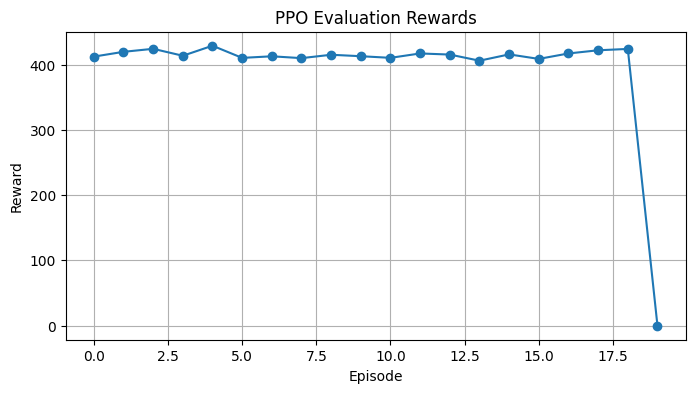

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\hp\Downloads\Project_RL\ppo_eval_video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


DependencyNotInstalled: MoviePy is not installed, run `pip install "gymnasium[other]"`

In [ ]:
import os
import numpy as np
import gymnasium as gym
from gymnasium import Wrapper
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

# 1. Define the reward shaping wrapper
class RewardShapingWrapper(Wrapper):
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        shaped_reward = (
            info.get("rewards", {}).get("high_speed_reward", 0)
            + info.get("rewards", {}).get("right_lane_reward", 0)
            + info.get("rewards", {}).get("on_road_reward", 0)
        )
        if info.get("crashed", False):
            shaped_reward -= 50
        return obs, shaped_reward, terminated, truncated, info

# 2. Create the environment
def make_env():
    def _init():
        config = {
    "observation": {
        "type": "OccupancyGrid",
        "features": ["presence", "on_road", "offroad", "speed", "heading"],
        "grid_size": [[-20, 20], [-20, 20]],  
        "grid_step": [5.0, 5.0],
        "scaling": 5.5,
    },
    "action": {
        "type": "ContinuousAction",
    },
    "lanes_count": 4,
    "vehicles_count": 15,
    "controlled_vehicles": 1,
    "duration": 40,
    "simulation_frequency": 15,
    "policy_frequency": 5,
    "screen_width": 600,
    "screen_height": 150,
    "centering_position": [0.3, 0.5],
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": True,
    "manual_control": False,
    "real_time_rendering": False,
}

        env = gym.make("highway-v0", render_mode="rgb_array", config=config)
        env = RewardShapingWrapper(env)
        return env
    return _init

# 3. Create the vectorized environment
vec_env = DummyVecEnv([make_env()])

# 4. Train the PPO agent
model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1,
    learning_rate=5e-4,
    n_steps=1024,
    batch_size=64,
    n_epochs=20,
    gamma=0.95,
    policy_kwargs=dict(net_arch=dict(pi=[256, 256], vf=[256, 256])),
)

model.learn(total_timesteps=100_000)
model.save("ppo_highway_continuous")

# 5. Evaluate the trained agent
eval_env = make_env()()
rewards = []
for ep in range(20):
    obs, _ = eval_env.reset()
    terminated = truncated = False
    total_reward = 0
    while not (terminated or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = eval_env.step(action)
        total_reward += reward
    rewards.append(total_reward)
    print(f"Episode {ep+1}: Reward = {total_reward:.2f}")

# 6. Plot the evaluation rewards
plt.figure(figsize=(8, 4))
plt.plot(rewards, marker="o")
plt.title("PPO Evaluation Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# 7. Record a video of the agent
video_folder = "ppo_eval_video"
os.makedirs(video_folder, exist_ok=True)

video_env = gym.make("highway-v0", render_mode="rgb_array")
video_env = RewardShapingWrapper(video_env)
video_env = RecordVideo(video_env, video_folder=video_folder, episode_trigger=lambda e: True)

obs, _ = video_env.reset()
terminated = truncated = False
while not (terminated or truncated):
    action, _ = model.predict(obs, deterministic=True)
    obs, _, terminated, truncated, _ = video_env.step(action)

video_env.close()
print(f"Video saved in {video_folder}")


In [33]:
! pip install "gymnasium[other]"


   ---------------------------------------- 0.0/31.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/31.2 MB ? eta -:--:--
   - -------------------------------------- 0.8/31.2 MB 2.6 MB/s eta 0:00:12
   -- ------------------------------------- 1.6/31.2 MB 2.5 MB/s eta 0:00:13
   -- ------------------------------------- 2.1/31.2 MB 2.5 MB/s eta 0:00:12
   --- ------------------------------------ 2.6/31.2 MB 2.6 MB/s eta 0:00:12
   ---- ----------------------------------- 3.1/31.2 MB 2.6 MB/s eta 0:00:11
   ----- ---------------------------------- 3.9/31.2 MB 2.7 MB/s eta 0:00:11
   ----- ---------------------------------- 4.5/31.2 MB 2.7 MB/s eta 0:00:10
   ------ --------------------------------- 5.2/31.2 MB 2.7 MB/s eta 0:00:10
   ------- -------------------------------- 5.8/31.2 MB 2.8 MB/s eta 0:00:10
   -------- ------------------------------- 6.6/31.2 MB 2.8 MB/s eta 0:00:09
   --------- ------------------------------ 7.1/31.2 MB 2.8 MB/s eta 0:00:09
   ----------


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
from stable_baselines3.common.vec_env import VecVideoRecorder

eval_env = DummyVecEnv([make_env()])
eval_env = VecVideoRecorder(
    eval_env,
    video_folder="ppo_vecvideo",
    record_video_trigger=lambda x: x == 0,
    video_length=500,
    name_prefix="ppo-eval"
)

obs = eval_env.reset()
for _ in range(500):
    action, _ = model.predict(obs, deterministic=True)
    obs, _, dones, _ = eval_env.step(action)
    if dones:
        break

eval_env.close()


MoviePy - Building video c:\Users\hp\Downloads\Project_RL\ppo_vecvideo\ppo-eval-step-0-to-step-500.mp4.
MoviePy - Writing video c:\Users\hp\Downloads\Project_RL\ppo_vecvideo\ppo-eval-step-0-to-step-500.mp4



MoviePy - Done !
MoviePy - video ready c:\Users\hp\Downloads\Project_RL\ppo_vecvideo\ppo-eval-step-0-to-step-500.mp4
